In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image, ImageChops, ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D


Using TensorFlow backend.


In [2]:
# For Kaggle: checking folder structures 
for dirs, _, files in os.walk('/kaggle'):
    print(dirs)

/kaggle
/kaggle/lib
/kaggle/lib/kaggle
/kaggle/lib/kaggle/competitions
/kaggle/lib/kaggle/competitions/twosigmanews
/kaggle/input
/kaggle/input/resnet50
/kaggle/input/real-and-fake-face-detection
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_fake
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_real
/kaggle/input/my-images-test-dataset
/kaggle/input/my-images-test-dataset/test_images
/kaggle/input/my-images-test-dataset/test_images/edited
/kaggle/input/my-images-test-dataset/test_images/real
/kaggle/input/my-images
/kaggle/input/my-images/my_images
/kaggle/input/my-images/my_images/edited
/kaggle/input/my-images/my_images/real
/kaggle/config
/kaggle/working
/kaggle/working/.ipynb_checkpoints


In [3]:
# Configuration

TRAIN_DIR = '../input/my-images/my_images'               # folder with 2 subfolders for authentic and modified images
TEST_DIR = '../input/my-images-test-dataset/test_images' # folder with test images
TEMP_DIR= '/kaggle/temporary_images'
ELA_RATE = 85 # error ELA rate used when resaving an image
IMG_WIDTH = 256
IMG_HEIGHT = 256
N_EPOCHS = 20
BATCH_SIZE = 32
DROPOUT_RATE = 0.5
SPLIT_RATE = 0.1 # splitting proportion for training and validation datasets

In [4]:
def applyELA(filepath):
    """ Error Level Analysis (ELA) is taken from http://www.hackerfactor.com/papers/bh-usa-07-krawetz-wp.pdf
    Basically it permits identifying areas within an image that are at different compression levels. 
    With JPEG images the entire picture should be at roughly the same level. 
    If a section of the image is at a significantly different error level, then it likely indicates a digital modification.
   
    Args:
        filepath: path to the image to analyze        

    Returns:
        Image object - ELA picture
    """
    if not os.path.isdir(TEMP_DIR): 
        os.mkdir(TEMP_DIR)
    
    temp_filename = TEMP_DIR+'/temporary_image.jpg'
    original = Image.open(filepath).convert('RGB')
    original.save(temp_filename, 'JPEG', quality=ELA_RATE) #resave image at a known error rate, e.g. 95%
    temporary = Image.open(temp_filename)
    
    diff = ImageChops.difference(original, temporary)  # compute the difference between 2 images
    extrema = diff.getextrema()
    
    # if no change, then pixel has reached its local minima for error at that quality level. 
    # if there is a large amount of change, then the pixels are not at their local minima and are effectively original
   
    max_diff = max([ex[1] for ex in extrema])
    max_diff = 1 if max_diff == 0 else max_diff
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    return diff

In [5]:
original_train_n = sum([len(files) for r, d, files in os.walk(TRAIN_DIR+'/real')])
edited_train_n = sum([len(files) for r, d, files in os.walk(TRAIN_DIR+'/edited')])
original_test_n = sum([len(files) for r, d, files in os.walk(TEST_DIR+'/real')])
edited_test_n = sum([len(files) for r, d, files in os.walk(TEST_DIR+'/edited')])
print('Number of training images: {0} (original: {1}, modified: {2}) '.format(original_train_n+edited_train_n, original_train_n, edited_train_n))
print('Number of test images: {0} (original: {1}, modified: {2}) '.format(original_test_n+edited_test_n, original_test_n, edited_test_n))

Number of training images: 442 (original: 284, modified: 158) 
Number of test images: 39 (original: 29, modified: 10) 


In [6]:
def processImages(pathToImages):
    """ Function performs ELA processing 
    Args:
        pathToImages: path to the folder with image files      

    Returns:
        X: array with features
        
    """
    X = []
    for img in os.listdir(pathToImages):
        X.append(np.array(applyELA(pathToImages+'/'+img).resize((IMG_WIDTH, IMG_HEIGHT))).flatten() / 255.0)
    return X    


In [7]:
# Preparing training dataset

X_train_real = processImages(TRAIN_DIR+'/real')    
y_train_real = [1] * len(X_train_real)

X_train_edited = processImages(TRAIN_DIR+'/edited')    
y_train_edited = [0] * len(X_train_edited)

X_train = np.concatenate((X_train_real, X_train_edited), axis=0)
y_train = y_train_real + y_train_edited 

X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
print('X_train shape: {}'.format(X_train.shape))

X_train shape: (442, 128, 128, 3)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=SPLIT_RATE, random_state=1)

In [9]:
def create_classifier(optimizer, dropout, loss, metrics):
    classifier = Sequential() # Initialising the CNN    
    classifier.add(Conv2D(32, (3, 3), input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), activation = 'relu')) 
    classifier.add(MaxPooling2D(pool_size = (2, 2))) 
    classifier.add(Dropout(dropout))
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))
    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    
    classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return classifier

In [10]:

classifier = create_classifier(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], dropout=DROPOUT_RATE)
classifier.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)       

In [11]:
classifier_info = classifier.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data = (X_val, y_val), verbose = 2) #, callbacks=[early_stopping])

Train on 397 samples, validate on 45 samples
Epoch 1/40
 - 6s - loss: 0.6697 - accuracy: 0.6423 - val_loss: 0.7036 - val_accuracy: 0.4667
Epoch 2/40
 - 5s - loss: 0.6278 - accuracy: 0.6625 - val_loss: 0.6937 - val_accuracy: 0.4667
Epoch 3/40
 - 5s - loss: 0.6165 - accuracy: 0.6625 - val_loss: 0.6957 - val_accuracy: 0.4667
Epoch 4/40
 - 5s - loss: 0.6097 - accuracy: 0.6625 - val_loss: 0.6954 - val_accuracy: 0.4667
Epoch 5/40
 - 5s - loss: 0.5918 - accuracy: 0.6499 - val_loss: 0.6947 - val_accuracy: 0.4889
Epoch 6/40
 - 5s - loss: 0.5848 - accuracy: 0.6650 - val_loss: 0.6982 - val_accuracy: 0.5111
Epoch 7/40
 - 5s - loss: 0.5755 - accuracy: 0.6675 - val_loss: 0.6918 - val_accuracy: 0.6444
Epoch 8/40
 - 5s - loss: 0.5472 - accuracy: 0.6599 - val_loss: 0.6871 - val_accuracy: 0.5556
Epoch 9/40
 - 5s - loss: 0.5302 - accuracy: 0.7128 - val_loss: 0.6786 - val_accuracy: 0.6000
Epoch 10/40
 - 5s - loss: 0.5292 - accuracy: 0.7003 - val_loss: 0.6488 - val_accuracy: 0.6000
Epoch 11/40
 - 5s - loss

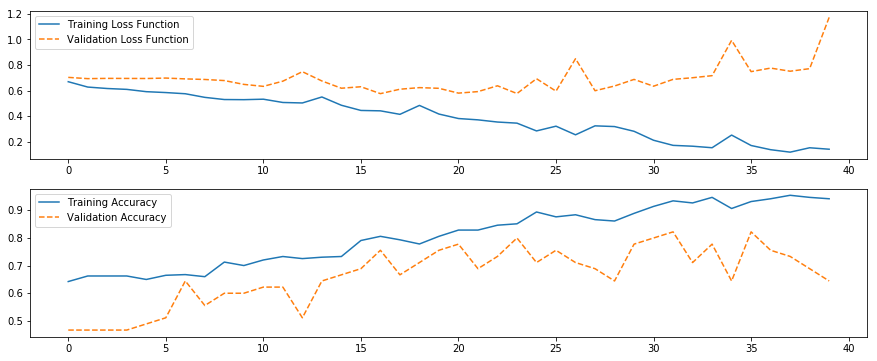

In [12]:
fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].plot(classifier_info.history['loss'], label="Training Loss Function")
ax[0].plot(classifier_info.history['val_loss'], label="Validation Loss Function", ls='--')
legend = ax[0].legend(loc='best')

ax[1].plot(classifier_info.history['accuracy'], label="Training Accuracy")
ax[1].plot(classifier_info.history['val_accuracy'], label="Validation Accuracy", ls='--')
legend = ax[1].legend(loc='best')

In [19]:
print('Confusion matrix for training set:')
train_predictions = np.where(classifier.predict(X_train) > 0.5, 1, 0)
print(confusion_matrix(y_train, train_predictions))
print('\n')
print(classification_report(y_train, train_predictions))

print('Confusion matrix for validation set:')
val_predictions = np.where(classifier.predict(X_val) > 0.5, 1, 0)
print(confusion_matrix(y_val, val_predictions))
print('\n')
print(classification_report(y_val, val_predictions))

Confusion matrix for training set:
[[104  30]
 [  3 260]]


              precision    recall  f1-score   support

           0       0.97      0.78      0.86       134
           1       0.90      0.99      0.94       263

    accuracy                           0.92       397
   macro avg       0.93      0.88      0.90       397
weighted avg       0.92      0.92      0.91       397

Confusion matrix for validation set:
[[10 14]
 [ 2 19]]


              precision    recall  f1-score   support

           0       0.83      0.42      0.56        24
           1       0.58      0.90      0.70        21

    accuracy                           0.64        45
   macro avg       0.70      0.66      0.63        45
weighted avg       0.71      0.64      0.62        45



In [13]:
# Evaluating the model on unseen test images

X_test_real = processImages(TEST_DIR+'/real')    
y_test_real = [1] * len(X_test_real)

X_test_edited = processImages(TEST_DIR+'/edited')    
y_test_edited = [0] * len(X_test_edited)

X_test = np.concatenate((X_test_real, X_test_edited), axis=0)
y_test = y_test_real + y_test_edited 

X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
print('The dimensionality of the test dataset: {}'.format(X_test.shape))

The dimensionality of the test dataset: (39, 128, 128, 3)


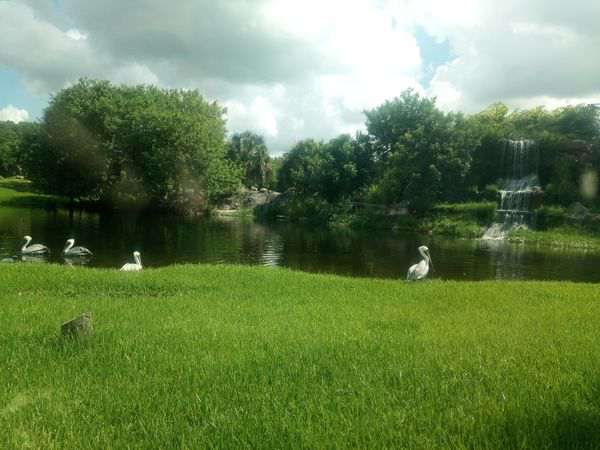

In [14]:
test_example_real = TEST_DIR+'/real/IMG_20190722_105058.jpg'
Image.open(test_example_real)

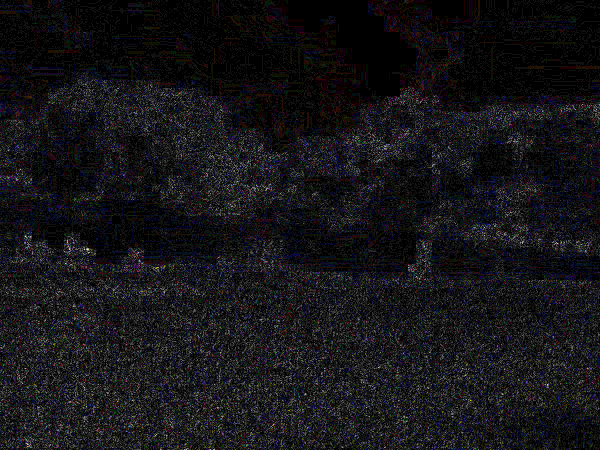

In [15]:
applyELA(test_example_real)

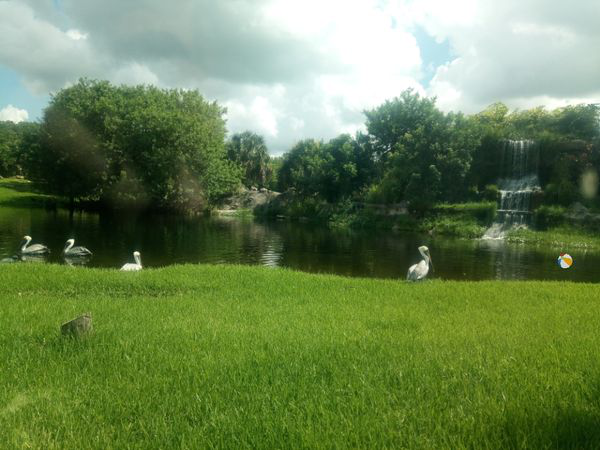

In [16]:
test_example_edited = TEST_DIR+'/edited/5I0KyNu.jpeg'
Image.open(test_example_edited)

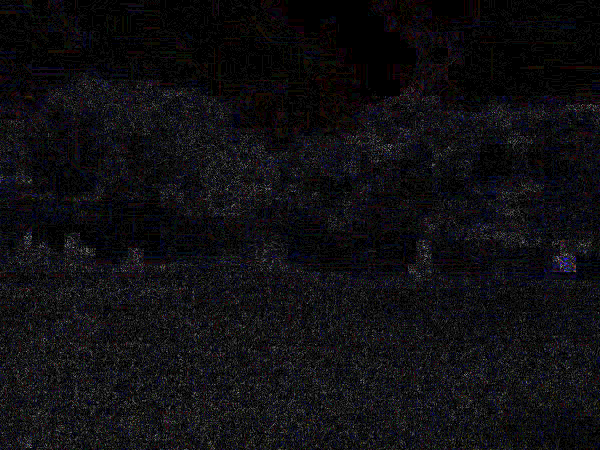

In [17]:
applyELA(test_example_edited)

In [18]:
print('Confusion matrix for test dataset:')
test_predictions = np.where(classifier.predict(X_test) > 0.5, 1, 0)
print(confusion_matrix(y_test, test_predictions))
print('\n')
print(classification_report(y_test, test_predictions))

Confusion matrix for test dataset:
[[ 0 10]
 [ 3 26]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.72      0.90      0.80        29

    accuracy                           0.67        39
   macro avg       0.36      0.45      0.40        39
weighted avg       0.54      0.67      0.59        39

